<h3>Setup</h3>

In [1]:
import torch
import sys
import platform

In [2]:
# MacOs
if platform.system() == "Darwin":
    main_dir = './'
    device = 'cpu'
    #device = 'mps' if torch.backends.mps.is_available()  else 'cpu'
    print(f"System: MacOs\nDevice: {device}\nMain_dir: {main_dir}")

# Linux
elif platform.system() == "Linux" and 'google.colab' not in sys.modules:
    main_dir = './'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"System: Linux\nDevice: {device}\nMain_dir: {main_dir}")

# Colab
elif platform.system() == "Linux" and 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    main_dir = '/content/drive/MyDrive/Università/Artificial Intelligence and Robotics/1° Anno/2° Semestre/Vision and Perception/Project/'
    sys.path.insert(0, main_dir)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"System: Colab\nDevice: {device}\nMain_dir: {main_dir}")

# Unknown
else:
    print("System unknown")


System: MacOs
Device: cpu
Main_dir: ./


In [3]:
from modules import dataset, training, model, inference, real_time_object_detector

<h3>Prepare datasets and loaders</h3>

In [4]:
PREPARE_CSV = False
PLOT_STATS = False

In [5]:
if PREPARE_CSV: 
    df = dataset.xml2csv(main_dir=main_dir, path_folder='../data/')
    df.head()

In [6]:
train_ds, valid_ds, test_ds = dataset.get_datasets(data_dir=main_dir+'../data/', csv_file='dataset.csv')

In [7]:
if PLOT_STATS: dataset.dataset_stats(dataset=train_ds)

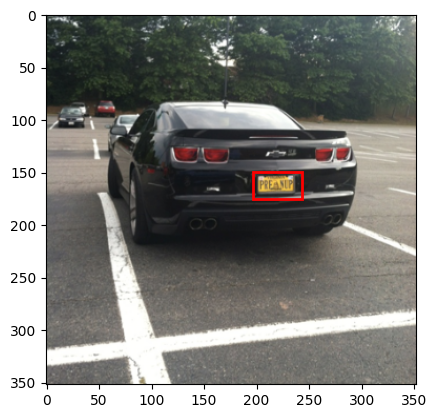

In [8]:
dataset.plot_image_from_dataset(dataset=train_ds, idx=0)

In [9]:
train_dl, valid_dl, test_dl = dataset.get_dataloaders(train_ds=train_ds, valid_ds=valid_ds, test_ds=test_ds, batch_size=8)

<h3>Training</h3>

In [10]:
TRAIN_MODEL=False
LOAD_MODEL=False

In [11]:
if TRAIN_MODEL:
    model = model.get_plateDetectorModel(num_classes=3, feature_extraction=True)
    if LOAD_MODEL:
        model.load_state_dict(torch.load(main_dir+"weights/model.pt"))

    optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                                lr = 0.005,
                                momentum = 0.9,
                                weight_decay = 0.0005)
    
    losses = training.training_and_validation(model=model.to(device),
                                                optimizer=optimizer,
                                                num_epochs=50,
                                                train_loader=train_dl,
                                                valid_loader=valid_dl,
                                                device=device,
                                                weights_dir=main_dir+'../weights/',
                                                verbose=2)
    
    training.plot_losses(train_epoch_losses=losses[0], valid_epoch_losses=losses[1])

<h3>Inference</h3>

In [12]:
COMPUTE_PREDICTIONS = False
PLOT_PREDICTIONS = False
COMPUTE_ONE_IMAGE = False
COMPUTE_REAL_TIME_OBJECT_DETECTOR = True

In [13]:
model = inference.load_model_for_inference(weights_dir=main_dir+'../weights/detector_weights/', device=device)

In [14]:
if COMPUTE_PREDICTIONS: images, predictions = inference.predict(model=model, data_loader=test_dl, device=device)

In [15]:
if PLOT_PREDICTIONS: inference.plot_grid_images(images=images, predictions=predictions)

In [16]:
if COMPUTE_ONE_IMAGE: 
    import cv2
    cv2_vehicles_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'color':(0,0,255), 'thickness':2, 'lineType':cv2.LINE_AA}
    cv2_plates_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'color':(0,255,0), 'thickness':2, 'lineType':cv2.LINE_AA}
    real_time_object_detector.plot_one_image(model=model, 
                                            img_param='../data/test/TEST_4.jpeg', 
                                            sr_weights_path='../weights/edsr_weights/EDSR_x3.pb', 
                                            cv2window=False, 
                                            cv2imshow=False, 
                                            plate_plot=True, 
                                            cv2_vehicles_cfg=cv2_vehicles_cfg, 
                                            cv2_plates_cfg=cv2_plates_cfg)

In [ ]:
if COMPUTE_REAL_TIME_OBJECT_DETECTOR: 
    import cv2
    cv2_vehicles_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'color':(0,0,255), 'thickness':2, 'lineType':cv2.LINE_AA}
    cv2_plates_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'color':(0,255,0), 'thickness':2, 'lineType':cv2.LINE_AA}
    real_time_object_detector.real_time_object_detector(model=model, 
                                                        video_path='../data/test/TEST.mp4', 
                                                        sr_weights_path='../weights/edsr_weights/EDSR_x3.pb',
                                                        cv2_vehicles_cfg=cv2_vehicles_cfg, 
                                                        cv2_plates_cfg=cv2_plates_cfg)